# Анализ бизнес-показателей приложения Procrastinate Pro+

## Описание данных

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях;
- выгрузка их покупок за этот период;
- рекламные расходы.

Таблица visits (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Загрузка данных и подготовка их к анализу

Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

Установка формата отображения данных без экспоненты:

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Сохранение данных о визитах, заказах и расходах в переменные. Просмотр информации о датафреймах и вывод на экран пяти произвольных строк из каждой таблицы.

In [3]:
visits = pd.read_csv('/datasets/visits_info.csv')
visits.info()
visits.sample(n=5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
211274,738535139711,UK,Android,organic,09.05.2019 15:06,09.05.2019 15:48
273259,680497695721,Germany,Android,LeapBob,02.09.2019 14:07,02.09.2019 14:11
205897,728963351414,United States,Mac,organic,29.10.2019 10:45,29.10.2019 10:47
297860,174899252198,UK,PC,LeapBob,11.10.2019 01:38,11.10.2019 01:47
169513,513791433815,United States,Android,TipTop,02.10.2019 15:05,02.10.2019 15:29


In [4]:
orders = pd.read_csv('/datasets/orders_info.csv')
orders.info()
orders.sample(n=5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
32012,419263491450,2019-07-30 23:59:07,4.990
38295,483568708610,2019-10-12 16:12:59,4.990
24544,448476047447,2019-10-16 06:11:23,4.990
29442,520659310653,2019-06-15 09:43:35,4.990
6270,680317225380,2019-07-05 13:01:50,4.990


In [5]:
costs = pd.read_csv('/datasets/costs_info.csv')
costs.info()
costs.sample(n=5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
1462,2019-05-23,WahooNetBanner,7.200
510,2019-09-28,RocketSuperAds,11.375
612,2019-07-12,TipTop,288.600
1322,2019-07-02,OppleCreativeMedia,14.750
993,2019-08-02,AdNonSense,26.250


Из выведенной информации видно, что в таблицах нет пропущенных значений.
Названия столбцов содержат пробелы и заглавные буквы, что может приводить к ошибкам при работе с данными, поэтому заменим все пробелы на знак `_` и приведём наименования к нижнему регистру.

In [6]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]

visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

Оптимизация данных для анализа - преобразуем данные о датах для дальнейших расчётов:

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%d.%m.%Y %H:%M')
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

Проверка датафреймов на дубликаты:

In [8]:
print('Количество дубликатов в датафрейме visits:', visits.duplicated().sum())
print('Количество дубликатов в датафрейме orders:', orders.duplicated().sum())
print('Количество дубликатов в датафрейме costs:', costs.duplicated().sum())

Количество дубликатов в датафрейме visits: 0
Количество дубликатов в датафрейме orders: 0
Количество дубликатов в датафрейме costs: 0


**Вывод**

Познакомившись с данными и обнаружив отсутствие пропущенных значений в таблицах, мы одновременно увидели, что названия столбцов содержат знаки пробела и заглавные буквы. Для исключения возможных ошибок при дальнейшей работе в названиях столбцов пробелы были заменены на знак нижнего подчёркивания, а сами названия приведены к нижнему регистру. В столбцах, содержащих даты, изменили тип данных на соответствующий. Также была проведена проверка на наличие дубликатов - дубликаты обнаружены не были. Таким образом мы подготовили датафреймы для анализа.

## Исследовательский анализ данных

Для построения пользовательских профилей с датой первого посещения и источником перехода на сайт напишем функцию `get_profiles()`. В ней сгруппируем значения датафрейма по пользовательскому ID и применим функцию `first()`:

In [9]:
def get_profiles(sessions):

    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby(['user_id'])
        .agg({'session_start': 'first', 'region': 'first', 'channel': 'first', 'device': 'first'})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # определяем дату первого посещения
    profiles['dt'] = profiles['first_ts'].dt.date
        
    # добавляем признак, является ли пользователь платящим
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    return profiles

Вызовем функцию `get_profiles()`, чтобы составить профили пользователей по данным сессий из датафрейма *visits*:

In [10]:
profiles = get_profiles(visits)
profiles

,user_id,first_ts,region,channel,device,dt,payer
0,599326,2019-05-07 20:58:00,United States,FaceBoom,Mac,2019-05-07,True
1,4919697,2019-07-09 12:46:00,United States,FaceBoom,iPhone,2019-07-09,False
2,6085896,2019-10-01 09:58:00,France,organic,iPhone,2019-10-01,False
3,22593348,2019-08-22 21:35:00,Germany,AdNonSense,PC,2019-08-22,False
4,31989216,2019-10-02 00:07:00,United States,YRabbit,iPhone,2019-10-02,False
...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:00,United States,TipTop,iPhone,2019-09-28,False
150004,999975439887,2019-10-21 00:35:00,UK,organic,PC,2019-10-21,False
150005,999976332130,2019-07-23 02:57:00,United States,TipTop,iPhone,2019-07-23,False
150006,999979924135,2019-09-28 21:28:00,United States,MediaTornado,PC,2019-09-28,False


Определим минимальную и максимальную дату привлечения пользователей, вызвав методы `.max()` и `min()`.

In [11]:
min_attr_date = (
    profiles.sort_values(by=['user_id', 'dt'])
    .groupby('user_id')
    .agg({'dt': 'first'})['dt']
    .min()
)

max_attr_date = (
    profiles.sort_values(by=['user_id', 'dt'])
    .groupby('user_id')
    .agg({'dt': 'first'})['dt']
    .max()
)

print('Минимальная дата привлечения пользователей:', min_attr_date)
print('Максимальная дата привлечения пользователей:', max_attr_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Выясним, из каких стран приходят посетители. Сгруппируем профили по региону и посчитаем количество уникальных ID функцией `.nunique()`, а также вычислим количество платящих пользователей в каждом из регионов.

In [12]:
(profiles.groupby('region')
     .agg({'user_id': 'nunique', 'payer': 'mean'})
     .sort_values(by='user_id', ascending=False)
     .rename(columns={'user_id': 'user_qty', 'payer': 'payer_rate'})
)

,user_qty,payer_rate
region,,
United States,100002,0.069
UK,17575,0.040
France,17450,0.038
Germany,14981,0.041


Больше всего посетителей пришло из США, там же и самая высокая доля платящих пользователей - 6.9%. Значительно меньшее число платящих пользователей было из остальных стран, при этом доля платящих из них по каждой из этих стран составляет около 4%.

Узнаем, какими устройствами пользуются пользователи, и какую долю составляют платящие пользователи:

In [13]:
(profiles.groupby('device')
     .agg({'user_id': 'nunique', 'payer': 'mean'})
     .sort_values(by='user_id', ascending=False)
     .rename(columns={'user_id': 'user_qty', 'payer': 'payer_rate'})
)

,user_qty,payer_rate
device,,
iPhone,54479,0.062
Android,35032,0.059
PC,30455,0.050
Mac,30042,0.064


Самое распространённое устройство среди пользователей приложения - это iPhone, устройствами на Android пользуется примерно на треть меньше пользователей. Однако доля платящих пользователей среди обладателей iPhone и Android отличается мало. Видим почти одинаковое количество использования устройств PC и Mac. И самая большая доля платящих наблюдается у тех людей, которые заходили в приложение через устройства Mac.

Теперь проанализируем, по каким рекламным каналам шло привлечение пользователей. Аналогично выведем таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [14]:
(profiles.groupby('channel')
     .agg({'user_id': 'nunique', 'payer': 'mean'})
     .sort_values(by='user_id', ascending=False)
     .rename(columns={'user_id': 'user_qty', 'payer': 'payer_rate'})
)

,user_qty,payer_rate
channel,,
organic,56439,0.021
FaceBoom,29144,0.122
TipTop,19561,0.096
OppleCreativeMedia,8605,0.027
LeapBob,8553,0.031
WahooNetBanner,8553,0.053
RocketSuperAds,4448,0.079
MediaTornado,4364,0.036
YRabbit,4312,0.038


Крупнейшие каналы привлечения пользователей - Organic, FaceBoom и TipTop. Однако среди пользователей, пришедших через органический трафик, доля платящих наименьшая среди всех каналов. В лидерах по доле пользователей, которые совершили хотя бы одну покупку в приложении - FaceBoom, AdNonSense, TipTop, lambdaMediaAds, причём по количеству привлечённых пользователей канал lambdaMediaAds последний в списке.

**Вывод**

В этом шаге мы построили профили пользователей и определили минимальную и максимальную дату привлечения пользователей. Данные о пользовательских профилях позволили нам выяснить, что:
- пользователи приложения находятся в США, Великобритании, Франции и Германии, при этом американцев среди них наибольшее количество - больше, чем в остальных странах вместе взятых. Наибольшее количество платящих пользователей также из Америки, причём доля платящих пользователей там наибольшая по сравнению с другими странами;
- названия устройств, которые используют люди - iPhone, Android, PC и Mac. При этом больше всего пользователей, которые совершили хотя бы одну покупку в приложении, пользуется устройствами iPhone. На втором месте - Android-устройства, на третьем - Mac. Наименьшее количество платящих пользователей использовали PC;
- пользователи привлекались через 11 различных рекламных каналов (в том числе органический трафик organic). В тройке лидеров каналов привлечения - Organic, FaceBoom и TipTop (перечислены в порядке убывания количества привлечённых пользователей). Однако доля платящих пользователей, приходящих из Organic, наименьшая из всех. А вот максимальную долю плательщиков принёс второй сверху по количеству пользователей канал - FaceBoom.

## Построение отчётов и вычисления метрик
Расчитаем метрики по трём направлениям: продукт, продажи и маркетинг.

### Продукт:

Выясним, сколько людей пользуются приложением в день, неделю, месяц: рассчитаем DAU, WAU и MAU.
Для этого выделим год, месяц, число и неделю начала сессии в отдельные столбцы.

In [15]:
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date

Посчитаем DAU, WAU и MAU. Сгруппируем данные по дате, неделе и месяцу, посчитаем количество уникальных пользователей по столбцу *'user_id'* и найдём среднее.

In [16]:
dau_total = visits.groupby('session_date').agg({'user_id': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']). agg({'user_id': 'nunique'}).mean()

print('Количество уникальных пользователей в день - DAU:', int(dau_total))
print('Количество уникальных пользователей в неделю - WAU:', int(wau_total))
print('Количество уникальных пользователей в месяц - MAU:', int(mau_total))

Количество уникальных пользователей в день - DAU: 1684
Количество уникальных пользователей в неделю - WAU: 8353
Количество уникальных пользователей в месяц - MAU: 28989


Посмотрим, как менялись эти метрики во времени, для этого построим графики, отображающие изменения.

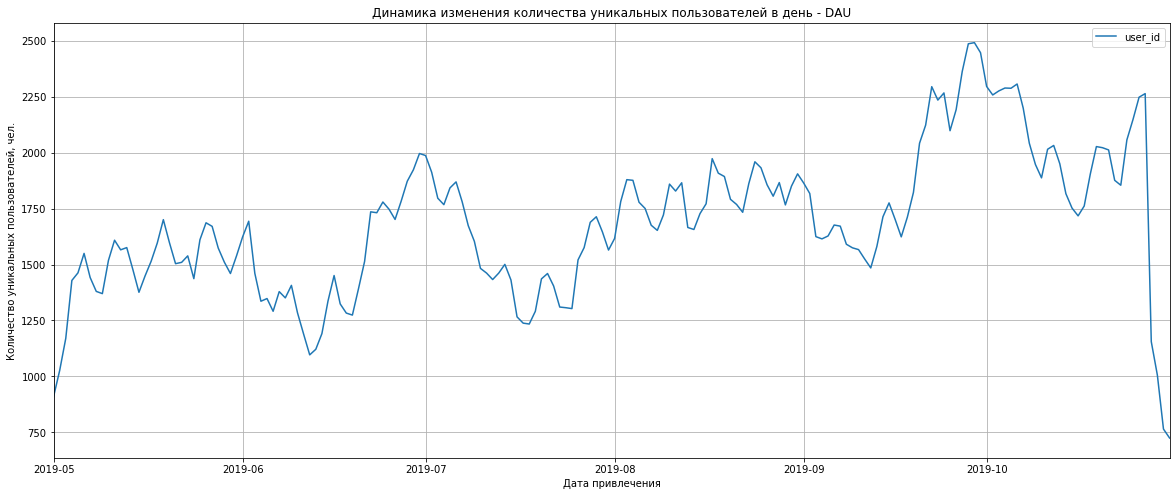

In [17]:
visits.groupby('session_date').agg({'user_id': 'nunique'}).plot(figsize=(20, 8), grid=True)
plt.title('Динамика изменения количества уникальных пользователей в день - DAU')
plt.xlabel('Дата привлечения')
plt.ylabel('Количество уникальных пользователей, чел.')
plt.show()

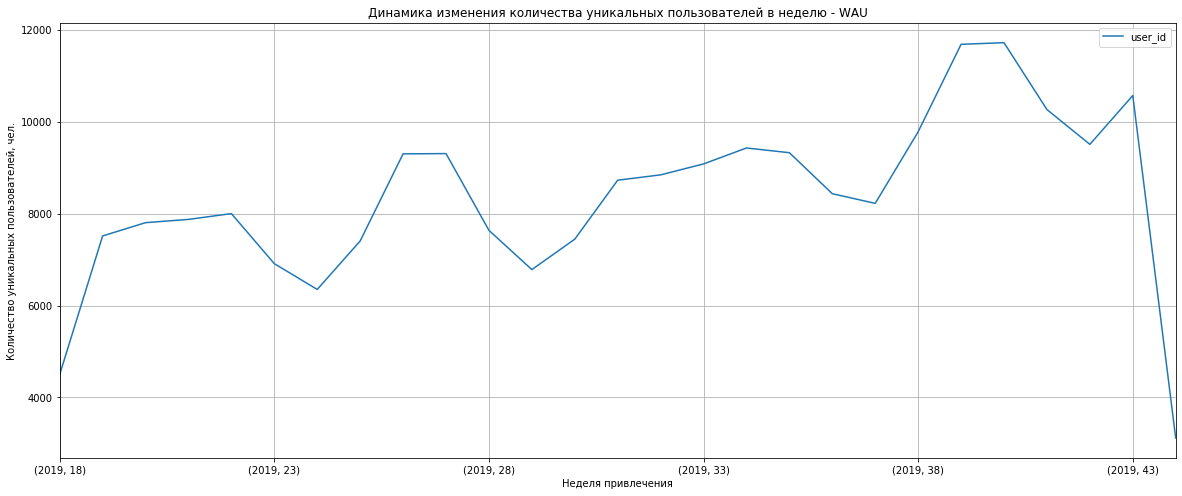

In [18]:
visits.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'}).plot(figsize=(20, 8), grid=True)
plt.title('Динамика изменения количества уникальных пользователей в неделю - WAU')
plt.xlabel('Неделя привлечения')
plt.ylabel('Количество уникальных пользователей, чел.')
plt.show()

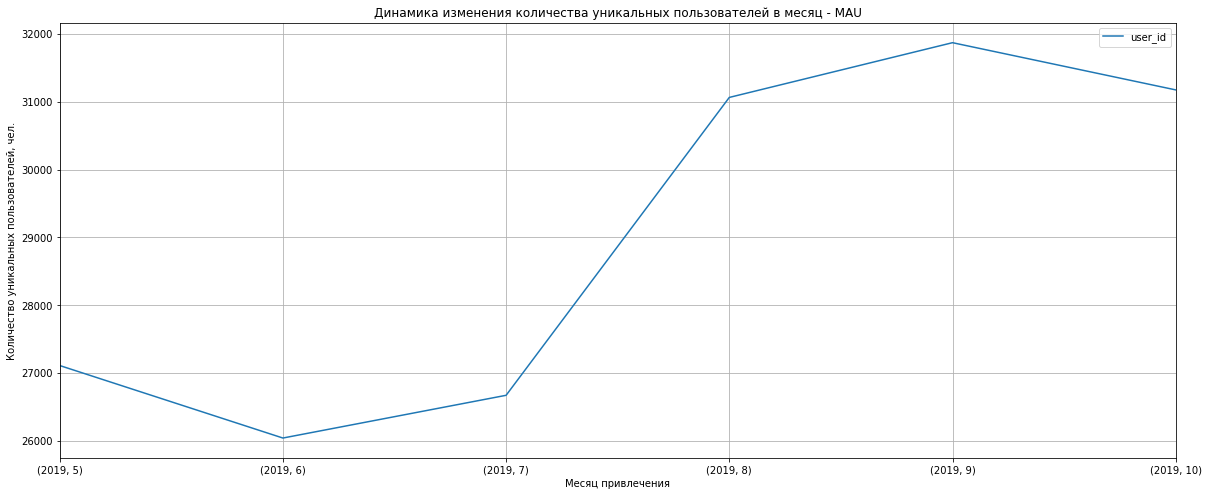

In [19]:
visits.groupby(['session_year', 'session_month']).agg({'user_id': 'nunique'}).plot(figsize=(20, 8), grid=True)
plt.title('Динамика изменения количества уникальных пользователей в месяц - MAU')
plt.xlabel('Месяц привлечения')
plt.ylabel('Количество уникальных пользователей, чел.')
plt.show()

Графики показывают, что количество уникальных пользователей с течением времени растёт (за исключением последних нескольких дней).

Посчитав общее количество пользователей, зашедших в приложение по дням, найдём общее число пользовательских сессий по дням. Построим по этим данным распределение и найдём среднее количество сессий в день.

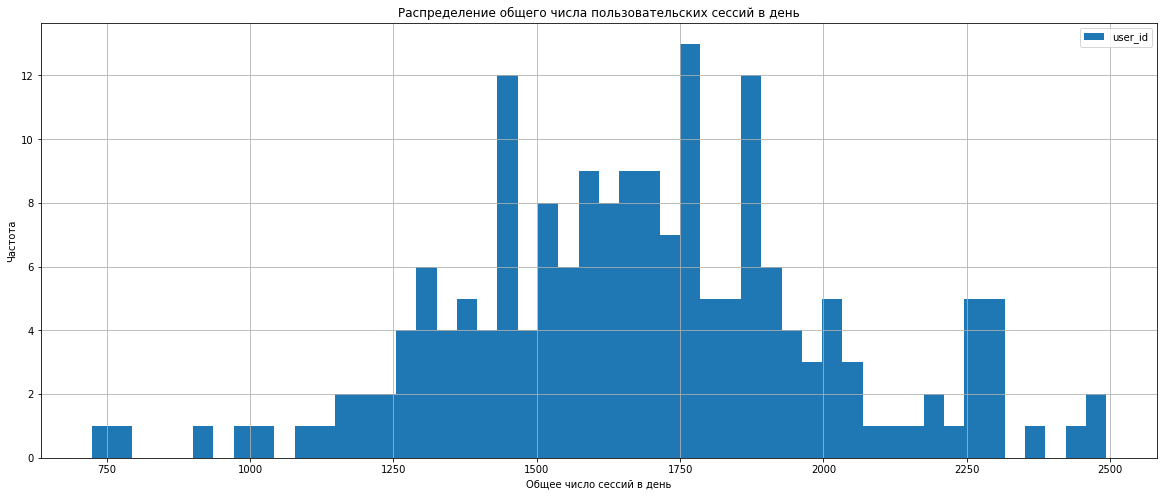

In [20]:
visits.groupby('session_date').agg({'user_id': 'count'}).plot(kind='hist', figsize=(20, 8), grid=True, bins=50)
plt.title('Распределение общего числа пользовательских сессий в день')
plt.xlabel('Общее число сессий в день')
plt.ylabel('Частота')
plt.show()

In [21]:
session_qty_mean = visits.groupby('session_date').agg({'user_id': 'count'}).mean()
print('Среднее количество сессий в день:', int(session_qty_mean))

Среднее количество сессий в день: 1684


Основная масса значений общего числа сессий в день лежит в промежутке от 1250 до 2000, при среднем значении в 1684 пользовательские сессии в день.

Благодаря DAU, WAU и MAU мы знаем, сколько пользователей заходят в приложение. Теперь узнаем, сколько времени они там проводят. Добавим к таблице visits дополнительный столбец с длительностью каждой сессии в минутах и посчитаем среднее значение.

In [22]:
visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds
print('Среднее значение длительности пользовательской сессии в секундах:', int(visits['session_duration_sec'].mean()))

Среднее значение длительности пользовательской сессии в секундах: 1800


Пользователи проводят в приложении в среднем по полчаса. Это довольно много - на первый взгляд всё отлично. Но прежде чем делать выводы, построим распределение.

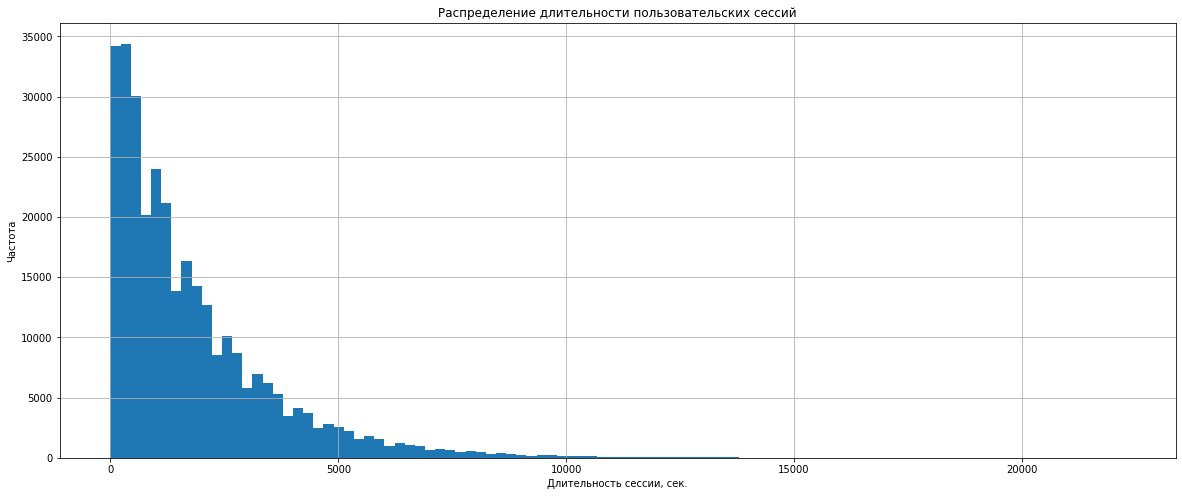

In [23]:
visits['session_duration_sec'].hist(figsize=(20, 8), grid=True, bins=100)
plt.title('Распределение длительности пользовательских сессий')
plt.xlabel('Длительность сессии, сек.')
plt.ylabel('Частота')
plt.show() 

Получилось экспоненциальное распределение с пиком в районе нуля. Очень многие сессии заканчиваются слишком быстро, так как пользователи могли по ошибке нажать на значок приложения, а затем быстро его закрыть. Поэтому все такие ошибочные сессии попадают в корзину со значением у нуля, а успешные сессии растягиваются в длинный хвост. Также в выборке присутствуют аномально длинные сессии.

Построим таблицу с параметрами этого распределения, применив метод `.describe()`.

In [24]:
visits['session_duration_sec'].describe()

count   309901.000
mean      1800.085
std       1803.190
min          0.000
25%        540.000
50%       1260.000
75%       2520.000
max      22260.000
Name: session_duration_sec, dtype: float64

Медианная продолжительность сессии, хотя и меньше средней, но тоже немаленькая - 21 минута.
В целом, со стороны продукта (т.е. самого приложения) картина выглядим довольно оптимистично. Перейдем к анализу продаж и изучим данные с этой точки зрения.

### Продажи:

Присоединим к таблице с профилями платящих пользователей *profiles[profiles['payer'] == True]*, таблицу с данными о покупках *orders* по столбцу *'user_id'* и сохраним результат в новой таблице *payer_profiles*. Затем вычислим промежуток времени между первым посещением и совершением покупки в секундах и запишем получившиеся значения в столбец *'time_before_order_sec'*.

In [25]:
payer_profiles = profiles[profiles['payer'] == True].merge(orders, on='user_id', how='outer')
payer_profiles['time_before_order_sec'] = (payer_profiles['event_dt'] - payer_profiles['first_ts']).dt.total_seconds()
payer_profiles

,user_id,first_ts,region,channel,device,dt,payer,event_dt,revenue,time_before_order_sec
0,599326,2019-05-07 20:58:00,United States,FaceBoom,Mac,2019-05-07,True,2019-05-07 20:59:09,4.990,69.000
1,599326,2019-05-07 20:58:00,United States,FaceBoom,Mac,2019-05-07,True,2019-05-08 06:01:28,4.990,32608.000
2,599326,2019-05-07 20:58:00,United States,FaceBoom,Mac,2019-05-07,True,2019-05-09 07:34:01,4.990,124561.000
3,46006712,2019-06-30 03:46:00,France,AdNonSense,Android,2019-06-30,True,2019-06-30 03:46:52,4.990,52.000
4,374052872,2019-08-08 15:42:00,United States,TipTop,Mac,2019-08-08,True,2019-08-16 07:44:47,4.990,662567.000
...,...,...,...,...,...,...,...,...,...,...
40207,999779032958,2019-07-04 10:56:00,United States,TipTop,iPhone,2019-07-04,True,2019-07-16 09:07:16,4.990,1030276.000
40208,999779032958,2019-07-04 10:56:00,United States,TipTop,iPhone,2019-07-04,True,2019-07-26 05:37:53,5.990,1881713.000
40209,999779032958,2019-07-04 10:56:00,United States,TipTop,iPhone,2019-07-04,True,2019-08-01 13:40:01,4.990,2429041.000
40210,999779032958,2019-07-04 10:56:00,United States,TipTop,iPhone,2019-07-04,True,2019-08-04 17:03:45,4.990,2700465.000


Посчитаем, сколько времени в среднем проходит с момента первого посещения до покупки, оставив в расчёте только первые покупки.

In [26]:
tbo_mean = payer_profiles.groupby(['user_id']).agg({'time_before_order_sec': 'min'}).mean()
print('Средний промежуток времени между первым визитом и покупкой в приложении:')
print('- в секундах:', int(tbo_mean))
print('- в часах: {:.2f}'.format(int(tbo_mean) / 3600))
print('- в днях: {:.2f}'.format(int(tbo_mean) / (3600 * 24)))

Средний промежуток времени между первым визитом и покупкой в приложении:
- в секундах: 162710
- в часах: 45.20
- в днях: 1.88


Для полноты картины построим распределение этой метрики и выведем на экран её числовое описание.

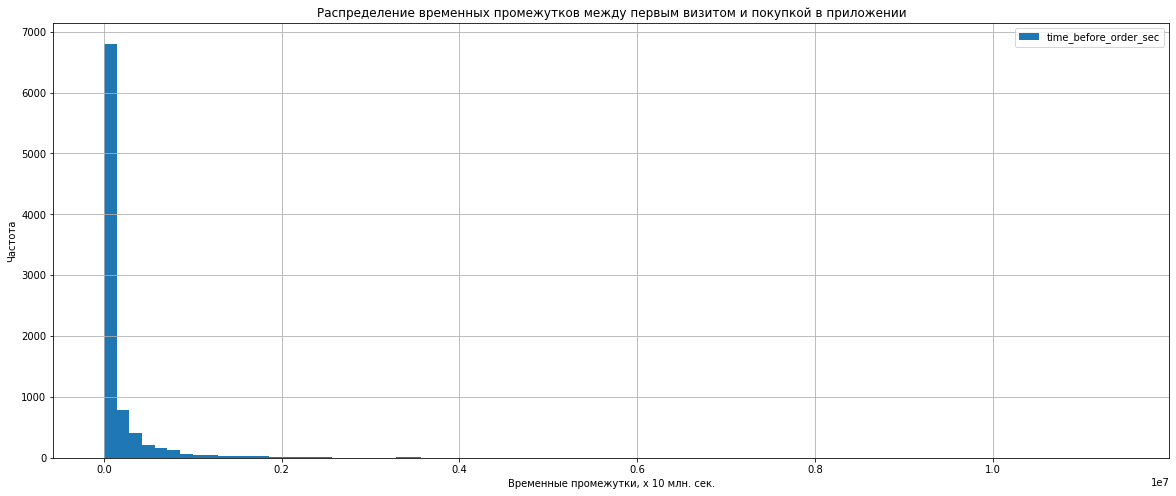

In [27]:
payer_profiles.groupby(['user_id']).agg({'time_before_order_sec': 'min'}).plot(kind='hist', figsize=(20, 8), grid=True, bins=80)
plt.title('Распределение временных промежутков между первым визитом и покупкой в приложении')
plt.xlabel('Временные промежутки, x 10 млн. сек.')
plt.ylabel('Частота')
plt.show()

In [28]:
payer_profiles.groupby(['user_id']).agg({'time_before_order_sec': 'min'}).describe()

,time_before_order_sec
count,8881.000
mean,162710.693
std,521540.166
min,0.000
25%,41.000
50%,70.000
75%,127732.000
max,11418895.000


На графике распределения виден большой пик около нуля, также виден "тонкий" хвост из больших значений. Большой пик у нуля можно объяснить тем, что скорее всего при установке приложения есть возможность использовать сразу платную версию (оплатить до установки). Медиана получилась в 70 секунд, то есть в половине случаев покупка происходит либо в момент установки, либо сразу после нее. Видим, что на среднее слишком сильно повлияли аномально длинные промежутки. Если смотреть на медиану, получили ещё лучший результат!



<br><br><br>
Рассчитаем среднее число покупок на одного пользователя за день. Расчёт будем проводить по таблице *orders*. Сначала добавим туда столбцы с днём, неделей, месяцем и годом покупки. Затем сгруппируем таблицу по столбцам *'user_id'* и *'event_date'* и посчитаем количество заказов по столбцу *'revenue'*. Получившуюся таблицу снова сгруппируем по *'event_date'*, и выведем среднее значение количества заказов. Построим график изменения среднего количества покупок на одного покупателя за день во времени.

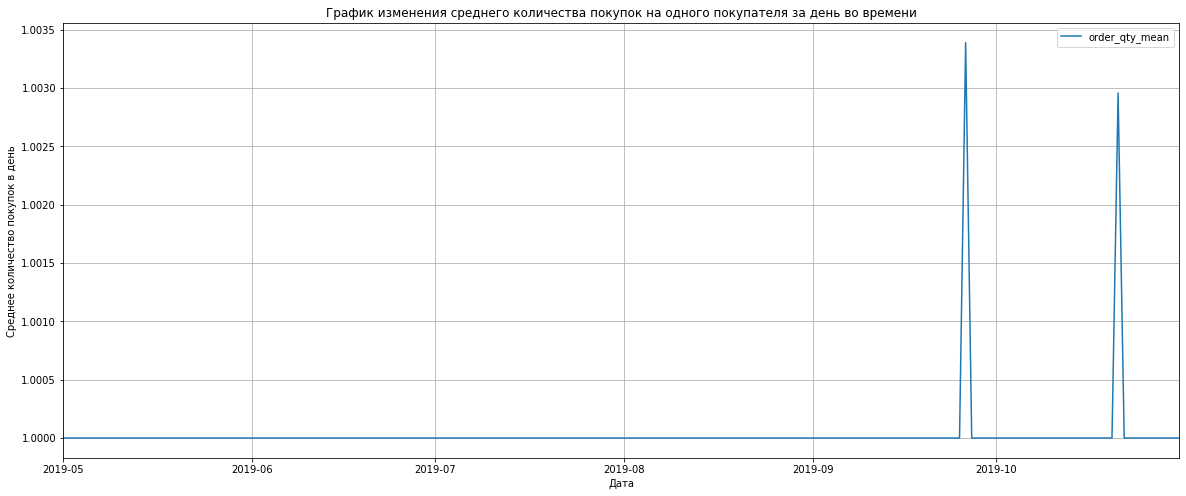

In [29]:
# добавляем в таблицу orders день, неделю, месяц и год покупки
orders['event_year'] = orders['event_dt'].dt.year
orders['event_month'] = orders['event_dt'].dt.month
orders['event_week'] = orders['event_dt'].dt.week
orders['event_date'] = orders['event_dt'].dt.date

# группируем таблицу orders по 'user_id' и 'event_date', считаем количество заказов
orders_per_day = (orders.groupby(['user_id', 'event_date'])
       .agg({'revenue': 'count'})
       .rename(columns={'revenue': 'order_qty'})
       .reset_index()          
)

# группируем таблицу orders_per_day по 'event_date', считаем среднее от количества заказов и строим график
ax = (orders_per_day
     .groupby('event_date')
     .agg({'order_qty': 'mean'})
     .rename(columns={'order_qty': 'order_qty_mean'})
     .reset_index()
     .plot(x='event_date', y='order_qty_mean', figsize=(20, 8), grid=True)
     )
ax.set_title('График изменения среднего количества покупок на одного покупателя за день во времени')
ax.set_xlabel('Дата')
ax.set_ylabel('Среднее количество покупок в день')
plt.show()

Рассчитаем среднее количество покупок на одного пользователя в день за весь период:

In [30]:
print('Среднее количество покупок на одного пользователя в день за весь период:', orders_per_day.groupby('event_date').agg({'order_qty': 'mean'})['order_qty'].mean())

Среднее количество покупок на одного пользователя в день за весь период: 1.0000345022303812


Можно сказать, что среднее ежедневное количество покупок на одного пользователя оставалось на уровне 1 пользователя на протяжении всего времени.

Теперь аналогичным образом визуализируем среднее число покупок на одного покупателя за неделю от времени.

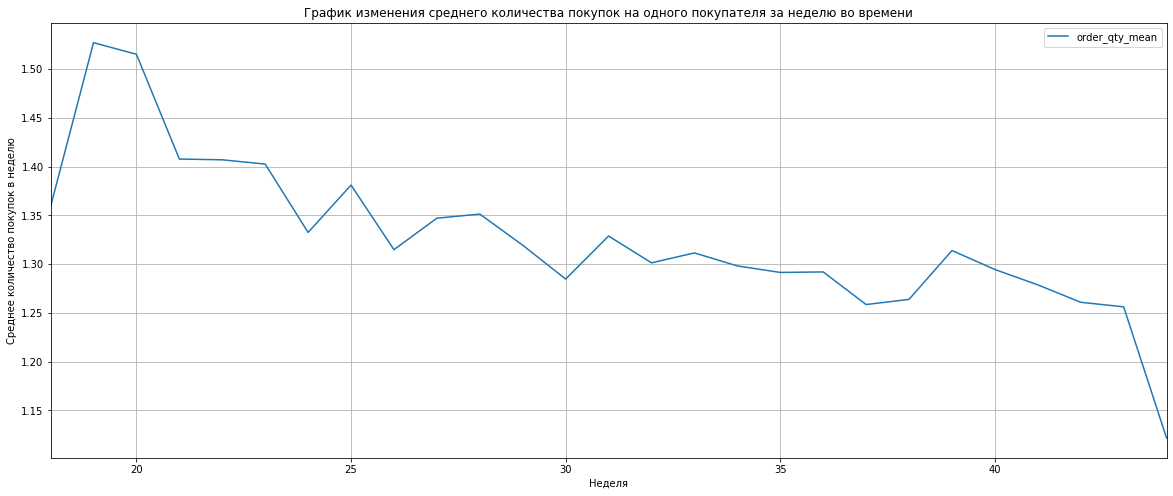

In [31]:
# группируем таблицу orders по 'user_id' и 'event_year', 'event_week', считаем количество заказов
orders_per_week = (orders.groupby(['user_id', 'event_year', 'event_week'])
       .agg({'revenue': 'count'})
       .rename(columns={'revenue': 'order_qty'})
       .reset_index()          
)

# группируем таблицу orders_per_week по 'event_year', 'event_week', считаем среднее от количества заказов и строим график
ax = (orders_per_week
     .groupby(['event_year', 'event_week'])
     .agg({'order_qty': 'mean'})
     .rename(columns={'order_qty': 'order_qty_mean'})
     .reset_index()
     .plot(x='event_week', y='order_qty_mean', figsize=(20, 8), grid=True)
     )
ax.set_title('График изменения среднего количества покупок на одного покупателя за неделю во времени')
ax.set_xlabel('Неделя')
ax.set_ylabel('Среднее количество покупок в неделю')
plt.show()

In [72]:
print('Среднее количество покупок на одного пользователя в неделю за весь период:', orders_per_week.groupby(['event_year', 'event_week']).agg({'order_qty': 'mean'})['order_qty'].mean())

Среднее количество покупок на одного пользователя в неделю за весь период: 1.3266628820826012


Среднее еженедельное количество покупок на одного пользователя на начало 20-ой недели превышало значение 1.5, а после 20-й недели начало постепенно снижаться. К 30-ой неделе это количество находилось на уровне примерно 1.3, а к концу исследуемого периода уменьшилось почти до 1.

Перейдём к визуализации среднего числа покупок на одного покупателя за месяц от времени. 

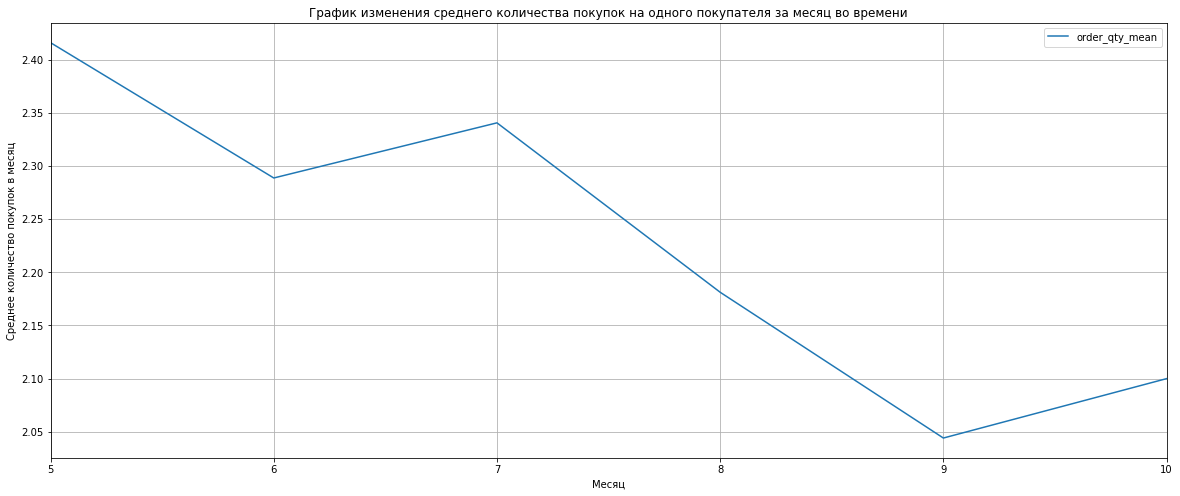

In [32]:
# группируем таблицу orders по 'user_id' и 'event_year', 'event_month', считаем количество заказов
orders_per_month = (orders.groupby(['user_id', 'event_year', 'event_month'])
       .agg({'revenue': 'count'})
       .rename(columns={'revenue': 'order_qty'})
       .reset_index()          
)

# группируем таблицу orders_per_month по 'event_year', 'event_month', считаем среднее от количества заказов и строим график
ax = (orders_per_month
     .groupby(['event_year', 'event_month'])
     .agg({'order_qty': 'mean'})
     .rename(columns={'order_qty': 'order_qty_mean'})
     .reset_index()
     .plot(x='event_month', y='order_qty_mean', figsize=(20, 8), grid=True)
     )
ax.set_title('График изменения среднего количества покупок на одного покупателя за месяц во времени')
ax.set_xlabel('Месяц')
ax.set_ylabel('Среднее количество покупок в месяц')
plt.show()

In [71]:
print('Среднее количество покупок на одного пользователя в месяц за весь период:', orders_per_month.groupby(['event_year', 'event_month']).agg({'order_qty': 'mean'})['order_qty'].mean())

Среднее количество покупок на одного пользователя в месяц за весь период: 2.228447784645054


Если смотреть на значение среднего помесячного количества покупок на одного покупателя за месяц, то видно падение этой метрики. Периодический рост есть, но он не компенсирует снижение. Таким образом, ежемесячное среднее значение количества покупок на одного покупателя в месяц снизилось с 2.40 до 2.10 к концу исследуемого периода.




Перейдём к анализу среднего чека. Рассчитаем средний чек за день. Воспользуемся данными таблицы *payer_profiles*, полученной выше. Добавим в таблицу столбцы с датой, неделей, месяцем и городом покупки. Затем сгруппируем данные по дате покупки и посчитаем среднее значение в столбце с суммой покупки. Построим график изменения этой метрики во времени.

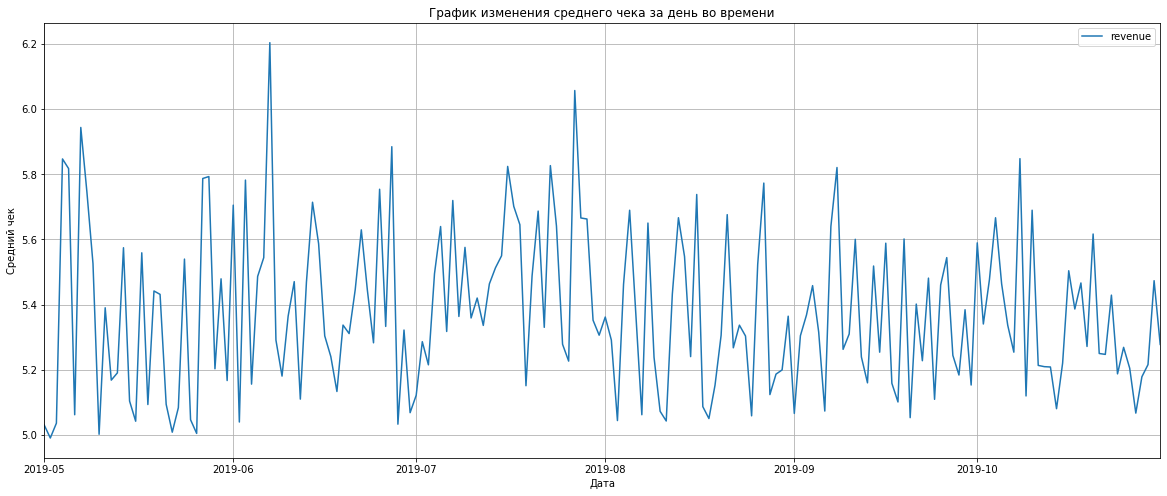

In [33]:
# добавляем в таблицу payer_profiles день, неделю, месяц и год покупки
payer_profiles['event_year'] = payer_profiles['event_dt'].dt.year
payer_profiles['event_month'] = payer_profiles['event_dt'].dt.month
payer_profiles['event_week'] = payer_profiles['event_dt'].dt.week
payer_profiles['event_date'] = payer_profiles['event_dt'].dt.date

# для каждой даты находим средний чек
# и строим график зависимости среднего чека за день от времени
payer_profiles.groupby('event_date').agg({'revenue': 'mean'}).plot(figsize=(20, 8), grid=True)
plt.title('График изменения среднего чека за день во времени')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

In [34]:
print('Среднее значение среднего чека за день: {:.2f}'.format(payer_profiles.groupby('event_date').agg({'revenue': 'mean'})['revenue'].mean()))

Среднее значение среднего чека за день: 5.38


Величина среднего чека динамично колеблется между значениями 5.0 и 5.8, а среднее значение находится на уровне 5.38. Видны два пика в июне и в июле на уровнях 6.2 и 6.1 соответственно.

Аналогичным образом построим графики изменения среднего чека за неделю и за месяц во времени. 

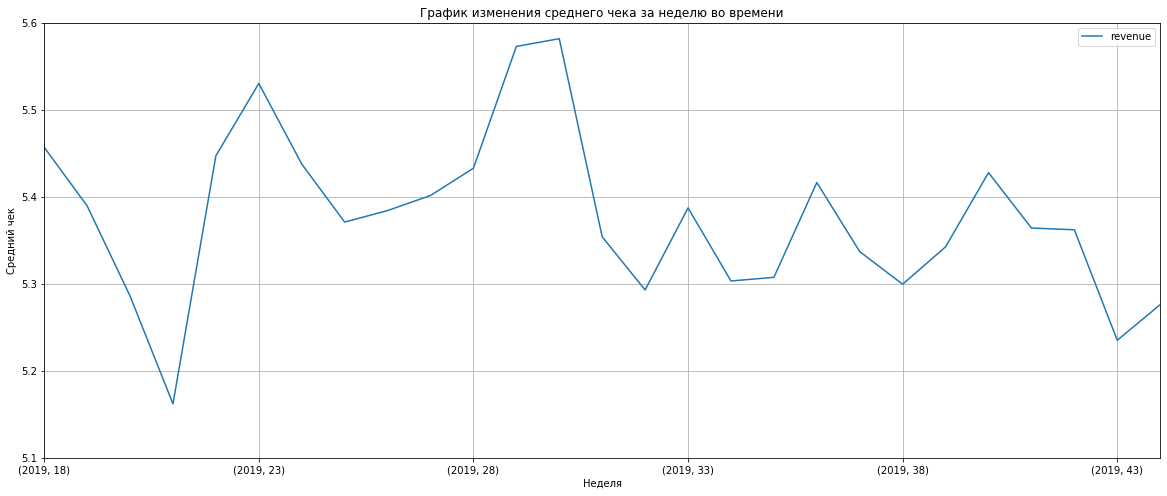

In [35]:
payer_profiles.groupby(['event_year', 'event_week']).agg({'revenue': 'mean'}).plot(figsize=(20, 8), grid=True)
plt.title('График изменения среднего чека за неделю во времени')
plt.xlabel('Неделя')
plt.ylabel('Средний чек')
plt.ylim(5.1, 5.6)
plt.show()

In [36]:
print('Среднее значение среднего чека за неделю: {:.2f}'.format(payer_profiles.groupby(['event_year', 'event_week']).agg({'revenue': 'mean'})['revenue'].mean()))

Среднее значение среднего чека за неделю: 5.38


Изменения еженедельной версии этой метрики во времени уже более плавное, чем ежедневное. Колебания на графике хоть и выглядят резкими, значения среднего чека лежат в довольно узкой области от 5.1 до 5.6. Среднее значение этой метрики совпадает с дневным показателем - 5.38.

Перейдем к визуализации изменения среднего чека за месяц во времени.

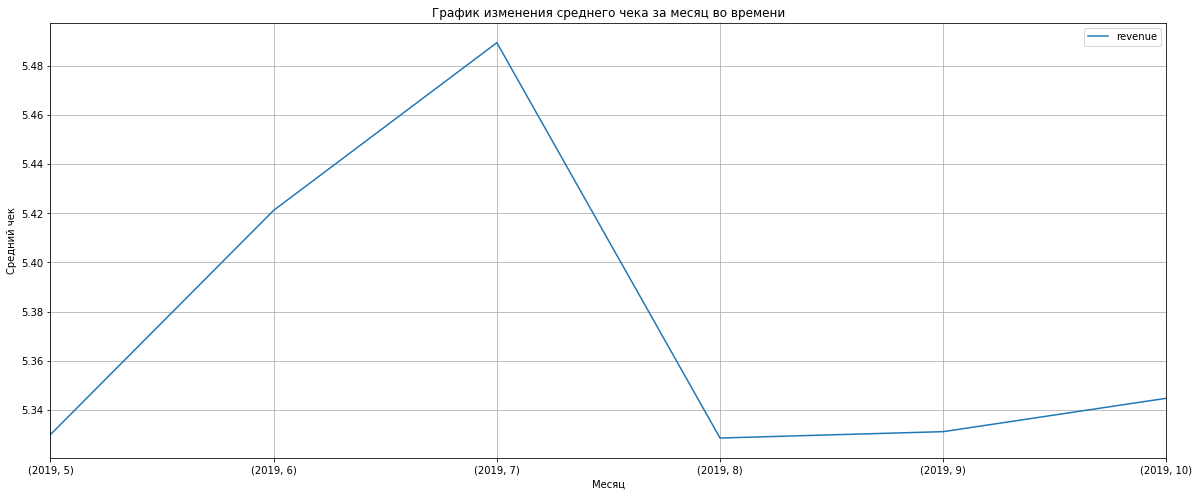

In [37]:
payer_profiles.groupby(['event_year', 'event_month']).agg({'revenue': 'mean'}).plot(figsize=(20, 8), grid=True)
plt.title('График изменения среднего чека за месяц во времени')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')
plt.show()

In [38]:
print('Среднее значение среднего чека за месяц: {:.2f}'.format(payer_profiles.groupby(['event_year', 'event_month']).agg({'revenue': 'mean'})['revenue'].mean()))

Среднее значение среднего чека за месяц: 5.37


Наименьшее значение ежемесячного среднего чека во времени видно в мае и в августе - 5.33. Наибольшее - в июле - 5.49. То есть изменения этой метрики во времени лежит в ещё более узком интервале от 5.33 до 5.49. Среднее значение при этом чуть ниже, чем недельное и дневное - 5.37.

### Маркетинг:

Посчитаем общую сумму расходов на маркетинг.

In [39]:
print('Общая сумма расходов на маркетинг: {:.2f}'.format(costs['costs'].sum()))

Общая сумма расходов на маркетинг: 105497.30


Выясним, как траты распределены по каналам привлечения. Сгруппируем таблицу *costs* по столбцу *'channel'* и посчитаем, какая сумма была потрачена по каждому из каналов.

In [40]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.300
FaceBoom,32445.600
WahooNetBanner,5151.000
AdNonSense,3911.250
OppleCreativeMedia,2151.250
RocketSuperAds,1833.000
LeapBob,1797.600
lambdaMediaAds,1557.600
MediaTornado,954.480


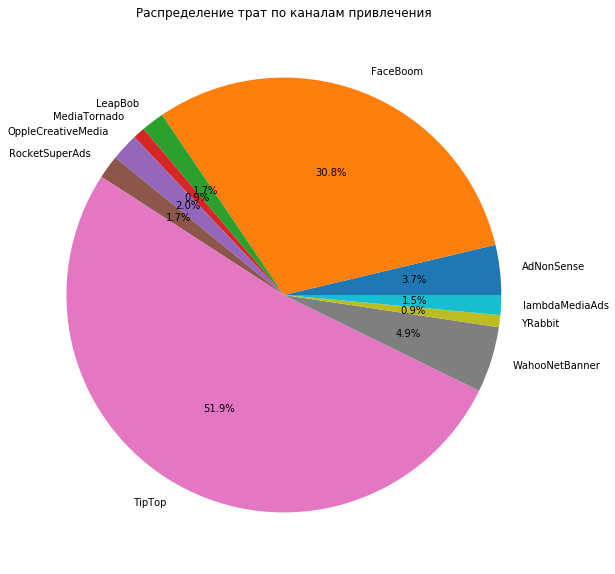

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(costs.groupby('channel').agg({'costs': 'sum'}).reset_index()['costs'], labels=costs.groupby('channel').agg({'costs': 'sum'}).reset_index()['channel'], autopct='%1.1f%%')
plt.title('Распределение трат по каналам привлечения')
plt.show()

Как видно из круговой диаграммы, львиная доля рекламного бюджета ушла на каналы привлечения TipTop и FaceBoom, на другие каналы пришлось от 0.9% до 4.9%.

Визуализируем, как менялись траты по каждому источнику трафика во времени. Построим общий график, а также увеличенную нижнюю часть этого же графика.

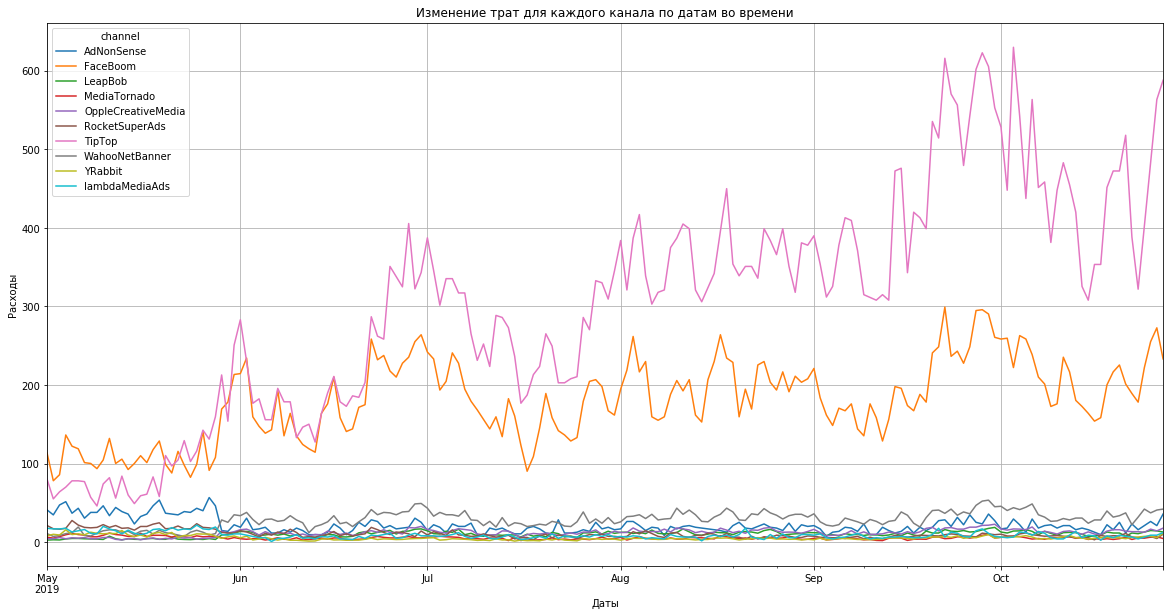

In [42]:
costs.pivot_table(
    index='dt',
    columns='channel',
    values='costs',
    aggfunc='sum',
).plot(figsize=(20, 10), grid=True)
plt.title('Изменение трат для каждого канала по датам во времени')
plt.xlabel('Даты')
plt.ylabel('Расходы')
plt.show()

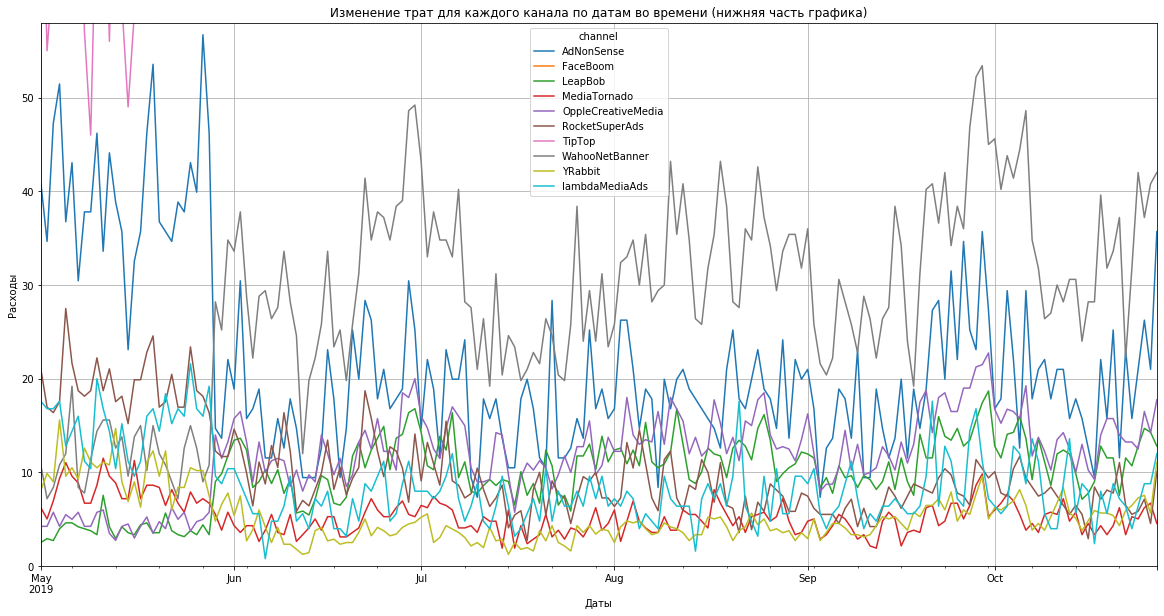

In [43]:
costs.pivot_table(
    index='dt',
    columns='channel',
    values='costs',
    aggfunc='sum',
).plot(figsize=(20, 10), grid=True)
plt.title('Изменение трат для каждого канала по датам во времени (нижняя часть графика)')
plt.xlabel('Даты')
plt.ylabel('Расходы')
plt.ylim(0, 58)
plt.show()

Из графиков видно, что затраты на рекламу в каналах TipTop и FaceBoom c течением времени увеличивались. По каналу AdNonSense расходы, наоборот, снижались. По другим каналам сложно что-либо сказать, так как по ним кривые слишком "скачут". Построим аналогичные графики для недельных и месячных расходов. Для этого добавим в таблицу *costs* столбцы с неделей, месяцем и годом расхода.

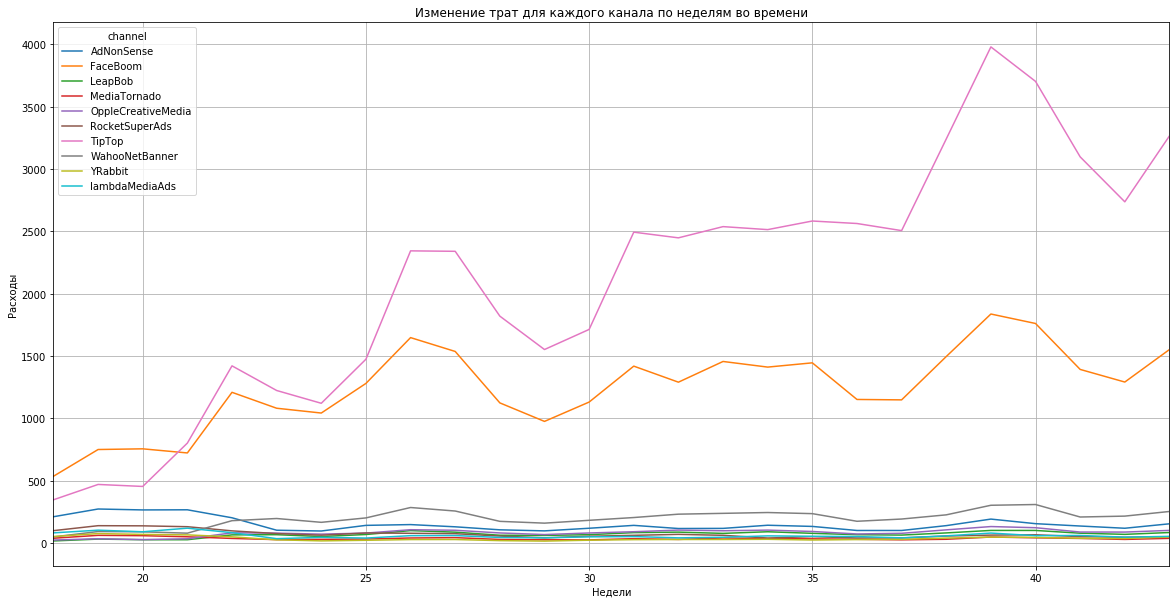

In [44]:
# добавляем в таблицу orders неделю, месяц и год расхода на рекламу
costs['dt_year'] = costs['dt'].dt.year
costs['dt_month'] = costs['dt'].dt.month
costs['dt_week'] = costs['dt'].dt.week

# строим график для понедельных расходов
costs.pivot_table(
    index='dt_week',
    columns='channel',
    values='costs',
    aggfunc='sum',
).plot(figsize=(20, 10), grid=True)
plt.title('Изменение трат для каждого канала по неделям во времени')
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.show()

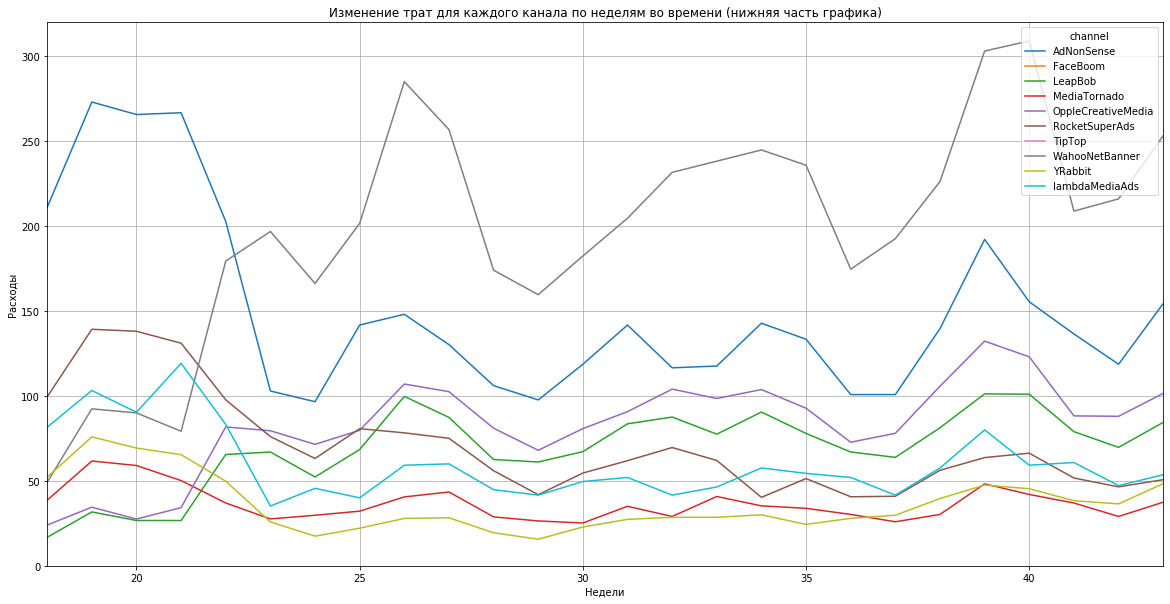

In [45]:
# увеличиваем нижнюю часть графика
costs.pivot_table(
    index='dt_week',
    columns='channel',
    values='costs',
    aggfunc='sum',
).plot(figsize=(20, 10), grid=True)
plt.title('Изменение трат для каждого канала по неделям во времени (нижняя часть графика)')
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.ylim(0, 320)
plt.show()

Теперь графики выглядят более плавными, а нижняя часть - информативнее. Здесь отчетливо видно, что затраты по каналу WahooNetBanner также увеличивались (но неравномерно), с первоначального значения 50 в неделю до максимального 310 в неделю. Затраты по остальным каналам кажутся примерно одинаковыми на протяжении всего исследуемого периода.

Построим теперь аналогичные графики для помесячных расходов на продвижение приложения.

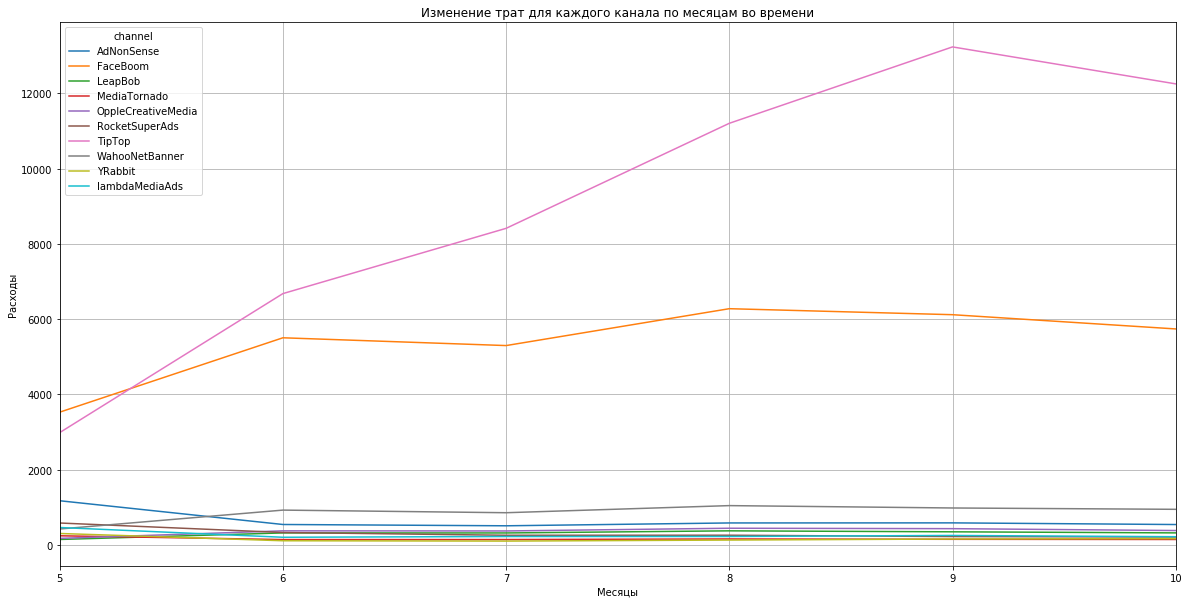

In [46]:
costs.pivot_table(
    index='dt_month',
    columns='channel',
    values='costs',
    aggfunc='sum',
).plot(figsize=(20, 10), grid=True)
plt.title('Изменение трат для каждого канала по месяцам во времени')
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.show()

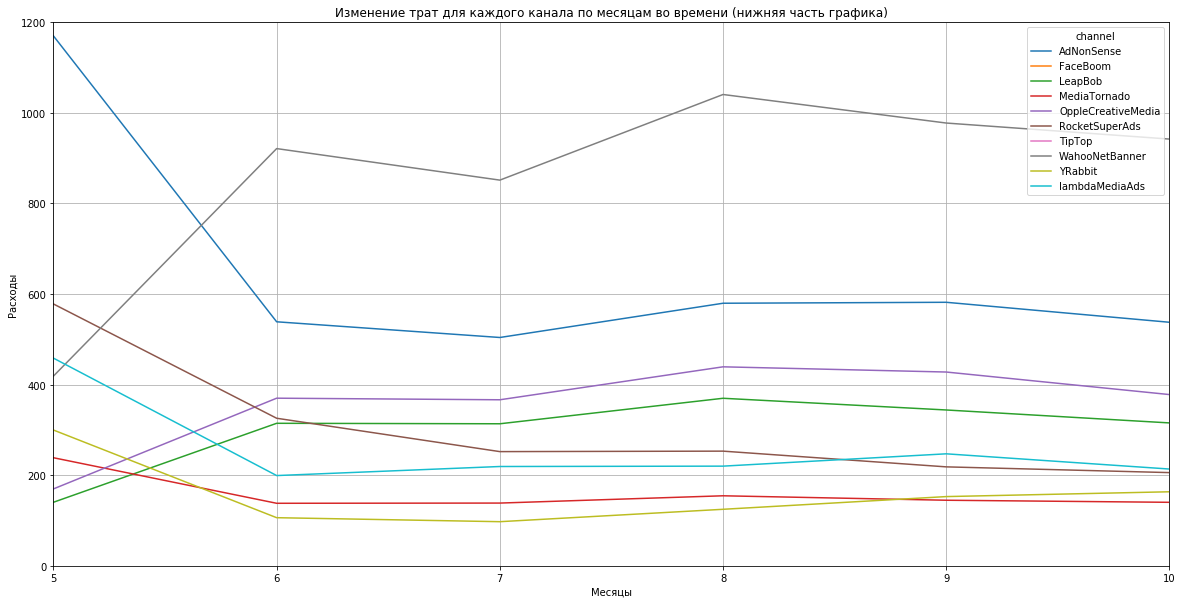

In [47]:
costs.pivot_table(
    index='dt_month',
    columns='channel',
    values='costs',
    aggfunc='sum',
).plot(figsize=(20, 10), grid=True)
plt.title('Изменение трат для каждого канала по месяцам во времени (нижняя часть графика)')
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.ylim(0, 1200)
plt.show()

Графики месячных трат выглядят очень плавными. По нему чётко прослеживается высокий темп роста расходов по каналу TipTop, небольшое и очень плавное увеличение бюджета по FaceBoom. Для небольших в смысле трат на продвижение каналов небольшой плавный рост трат наблюдается по каналам WahooNetBanner, OppleCreativeMedia и LeapBob. По остальным каналам видно небольшое снижение расходов в мае, затем графики очень близки к горизонтальной прямой линии, т.е. траты по ним оставались примерно на одном и том же уровне.

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника - посчитаем средний CAC. Для этого напишем функцию, возвращающую профили пользователей со стоимостью их привлечения.

In [48]:
def get_profiles(visits, orders, costs):
 
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})     # first_ts - время первого посещения
        .reset_index()
    )
 
    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
 
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
 
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})   # unique_users - столбец с числом пользователей
        .reset_index()
    )
 
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    costs['dt'] = costs['dt'].dt.date
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
 
    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
     
    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
 
    # органические пользователи из канала organic не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
 
    return profiles

Получаем профили пользователей с метрикой CAC (столбец *'acquisition_cost'*):

In [49]:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.231
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:00,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500
150004,999975439887,2019-10-21 00:35:00,organic,PC,UK,2019-10-21,2019-10-01,False,0.000
150005,999976332130,2019-07-23 02:57:00,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600
150006,999979924135,2019-09-28 21:28:00,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.206


Посчитаем средний CAC для всего проекта:

In [50]:
print('Среднее значение стоимости привлечения одного пользователя CAC для всего проекта:', profiles[profiles['channel'] != 'organic']['acquisition_cost'].mean())

Среднее значение стоимости привлечения одного пользователя CAC для всего проекта: 1.1274813239427588


Посчитаем средний CAC для каждого канала привлечения (источника трафика):

In [51]:
(profiles
     .groupby('channel')
     .agg({'acquisition_cost': 'mean'})
     .rename(columns={'acquisition_cost': 'acquisition_cost_mean'})
     .sort_values(by='acquisition_cost_mean', ascending=False)
)

,acquisition_cost_mean
channel,
TipTop,2.799
FaceBoom,1.113
AdNonSense,1.008
lambdaMediaAds,0.725
WahooNetBanner,0.602
RocketSuperAds,0.412
OppleCreativeMedia,0.250
YRabbit,0.219
MediaTornado,0.219


Самые дорогие пользователи в приложение пришли из каналов TipTop, FaceBoom и AdNonSense. Причём стоимость привлечения пользователя из канала TipTop более чем в 2 раза выше, чем стоимость пользователя из канала FaceBoom, и в десяток раз выше, чем из канала, например, OppleCreativeMedia.

**Вывод**

Проанализировав продукт, мы выяснили, что количество пользователей приложения с течением времени увеличивалось, а средняя и медианная продолжительности пользовательских сессий в приложении находятся на довольно хорошем уровне - 30 и 21 мин. соответственно.

Проанализировав продажи, было рассчитано, что среднее количество покупок в приложении на одного пользователя постепенно снижалось, однако средний чек не опускался ниже 5. В половине случаев покупка в приложении происходила в момент установки, либо сразу же после неё. 

Таким образом, получили довольно благоприятную картину со стороны продукта и продаж, однако, проведя анализ маркетинга, было обнаружено, что стоимость одного пользователя для каналов TipTop и FaceBoom, на которые тратилась основная часть рекламного бюджета и откуда приходило больше всего пользователей, оказалась очень высокой (порой даже в 5-10 раз выше, в сравнении со стоимостью пользователей, пришедших из других каналов).

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

В этом разделе зададим функции для расчёта и визуализации LTV, ROI, удержания и конверсии.

**Функция расчёта коэффициента удержания** `get_retention` со следующими параметрами:
- profiles — профили пользователей,
- visits — данные журнала сессий,
- observation_date — момент анализа,
- horizon_days — горизонт анализа в днях,
- ignore_horizon — опция «игнорировать горизонт анализа», по умолчанию False.

In [52]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция расчёта конверсии** `get_conversion` со следующими параметрами:
- profiles — профили пользователей,
- orders — информация о заказах,
- observation_date — момент анализа,
- horizon_days — горизонт анализа в днях,
- ignore_horizon — опция «игнорировать горизонт анализа», по умолчанию False.

In [53]:
def get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_orders = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_orders[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

**Функция для расчёта LTV и ROI** `get_ltv_roi`:

In [54]:
def get_ltv_roi(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Вспомогательная функция для сглаживания фрейма:

In [55]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

**Функция для визуализации удержания** `plot_retention`:

In [56]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

**Функция для визуализации конверсии** `plot_conversion`:

In [57]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Функция для визуализации LTV и ROI** `plot_ltv_roi`:

In [58]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Вывод**

Функции для создания профилей, расчёта удержания, конверсии, LTV и ROI, а также функции для визуализации этих метрик, необходимые для оценки окупаемости рекламы, заданы.

## Оценка окупаемости рекламы для привлечения пользователей

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы, затем пройдём по всем доступным характеристикам пользователей — устройствам первого посещения, странам и рекламным каналам.

### Анализ общей окупаемости рекламы

На календаре 1 ноября 2019 года. Так как в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения, то установим горизонт анализа в 14 дней.

In [59]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

Рассчитаем и визуализируем LTV и ROI, вызвав функции `get_ltv()` и `plot_ltv_roi()`.

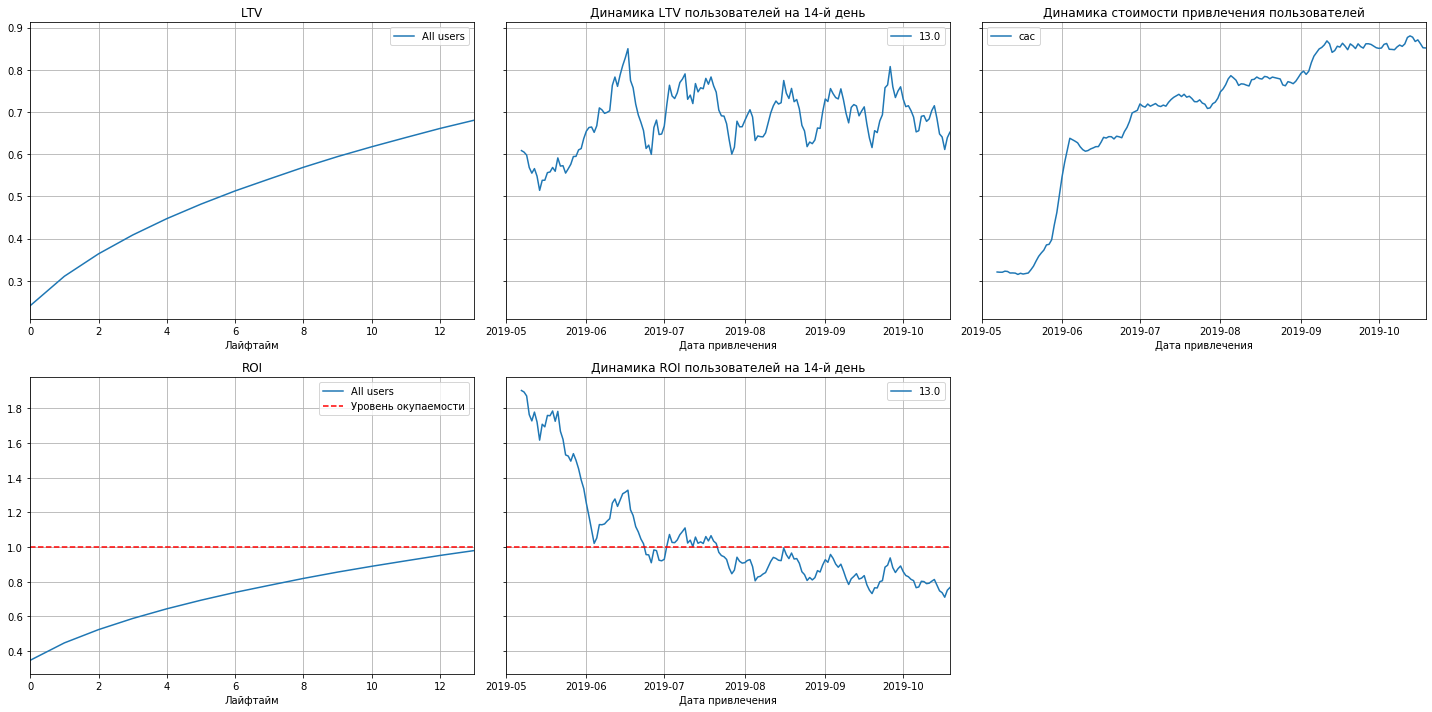

In [60]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- LTV стабилен, значит, качество пользователей не изменилось;
- Реклама не окупается. ROI к концу второй недели всё ещё меньше 100%;
- CAC увеличивается, а ROI наоборот, снижается.

### Анализ окупаемости рекламы с разбивкой по устройствам

Начнём с разбивки по устройствам: передадим параметру dimensions столбец *'device'*.

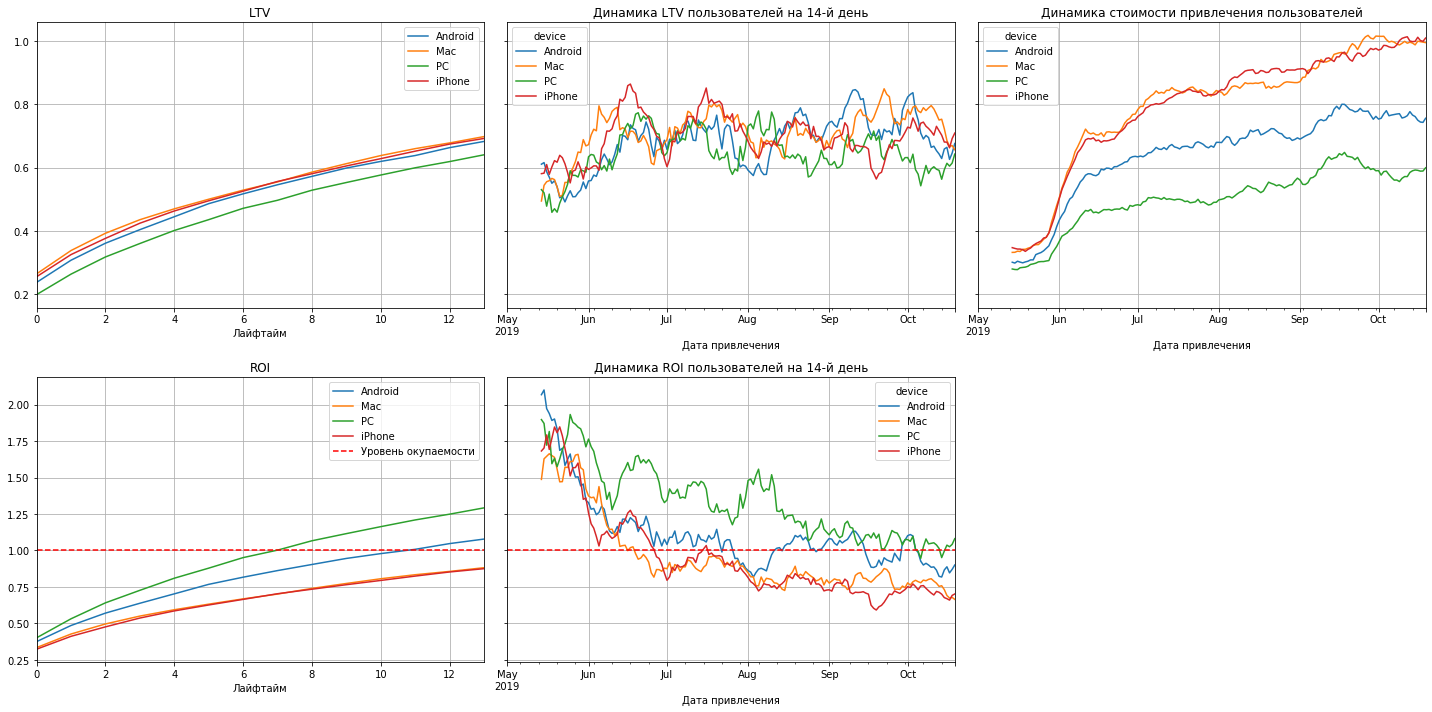

In [61]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вот что говорят графики:
- пользователи Android и PC окупаются, а вот пользователи iPhone и Mac - нет;
- стоимость привлечения растёт по всем устройствам, но пользователи PC и Android обходятся дешевле, чем пользователи iPhone и Mac;
- LTV по-прежнему стабилен.

### Анализ окупаемости рекламы с разбивкой по странам

Перейдём к странам.

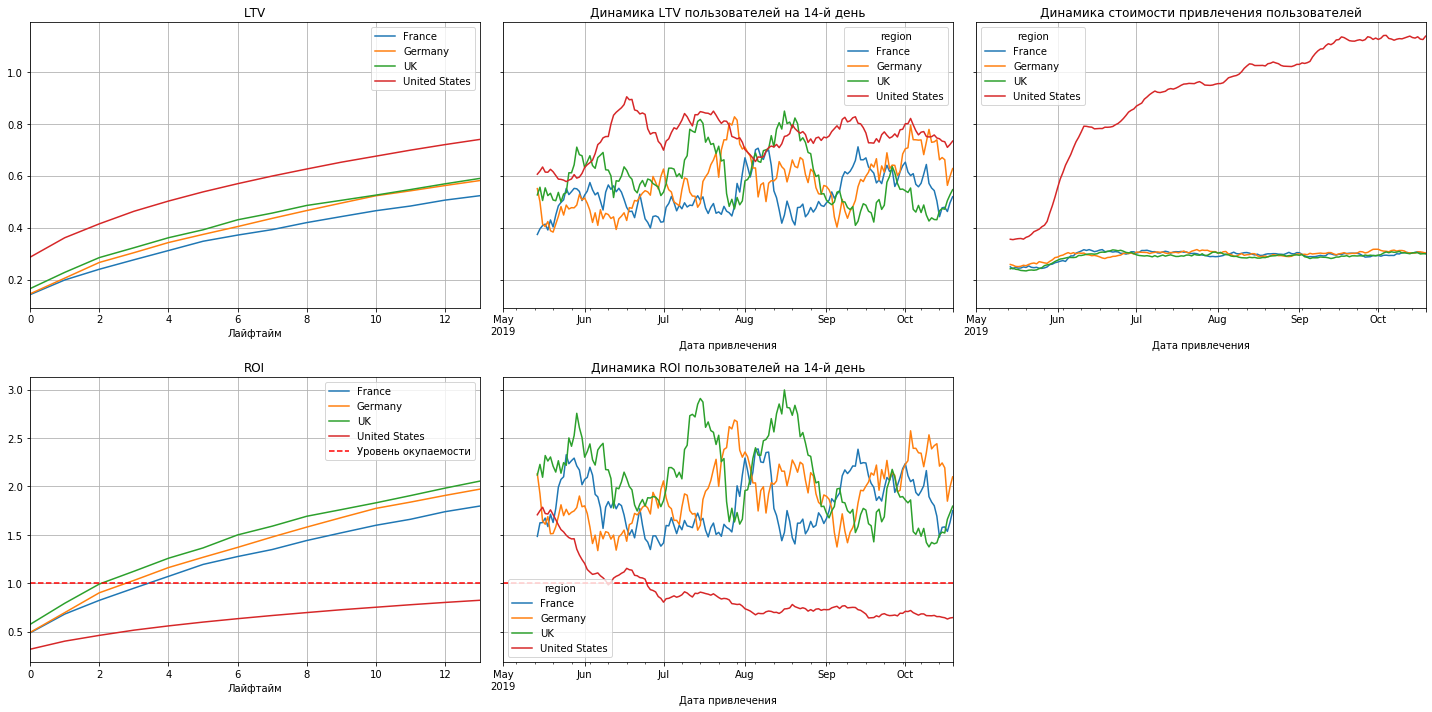

In [62]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- Снова видим стабильный LTV;
- Пользователи из США не окупаются, а вот по остальным странам видим намного более позитивную картину: довольно быструю окупаемость показывают пользователи из Великобритании, Германии и Франции;
- Для всех стран, кроме США, ROI стабилен, а в США он падает;
- CAC для Великобритании, Германии и Франции стабилен, он растёт только для США.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

Теперь проверим источники привлечения *'channel'*.

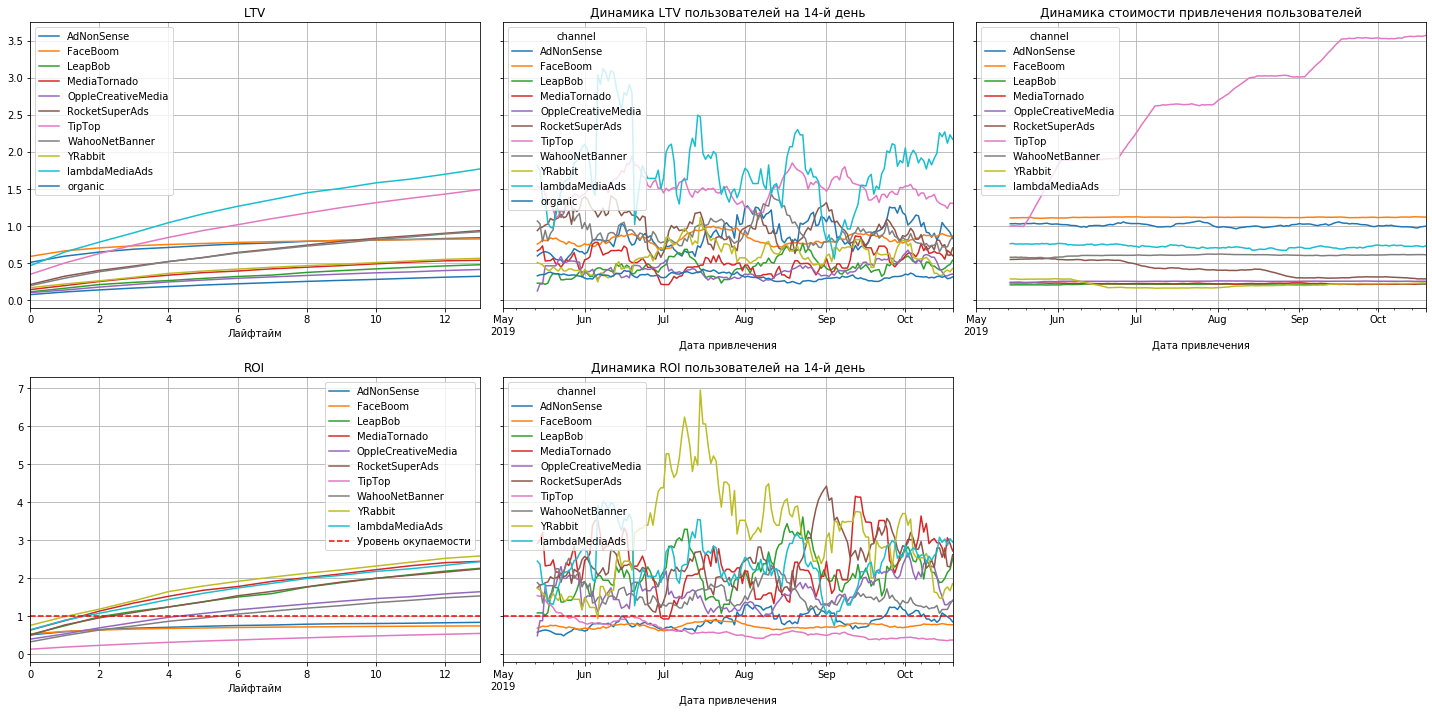

In [63]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv_roi(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Графики показывают:
- пользователи из каналов привлечения AdNonSense, TipTop и FaceBoom не окупаются (ROI ниже уровня окупаемости), в то же время пользователи из других каналов окупаются достаточно быстро;
- CAC для всех каналов достаточно стабилен (для некоторых каналов он даже немного снизился со временем), однако CAC для канала TipTop очень энергично растёт.

В целом видно, что не окупаются пользователи из США, пользователи iPhone и Mac и пользователи, приходящие из каналов AdNonSense, TipTop и FaceBoom. Причём для США и для канала TipTop наблюдается постоянный рост CAC. Проанализируем конверсию и удержание, чтобы получить больше информции о проблеме.

### Анализ конверсии и удержания

Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion() с разбивкой по устройствам.

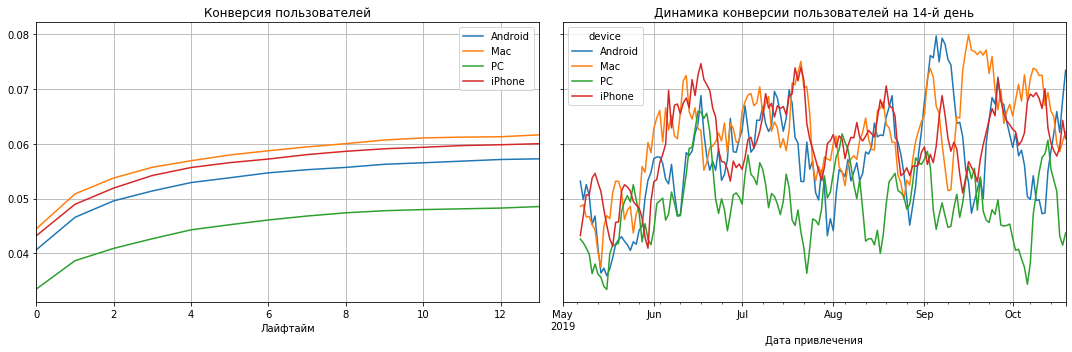

In [64]:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи iPhone и Mac конвертируются лучше остальных. Самую низкую конверсию показывают пользователи PC.

Проделаем то же самое по странам.

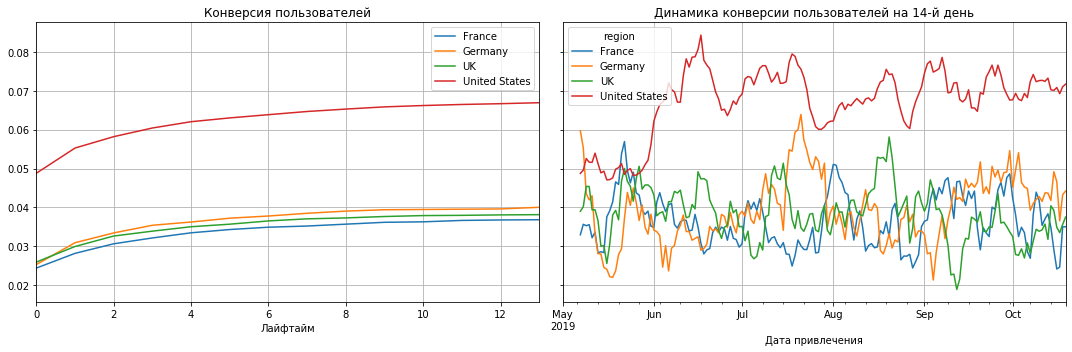

In [65]:
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Получается, что пользователи из США конвертируются в 2 раза лучше других, но при этом они не окупаются. Конверсия пользователей из остальных стран находится приблизительно на одном уровне.

Посмотрим на картину конверсии с разбивкой по каналу привлечения.

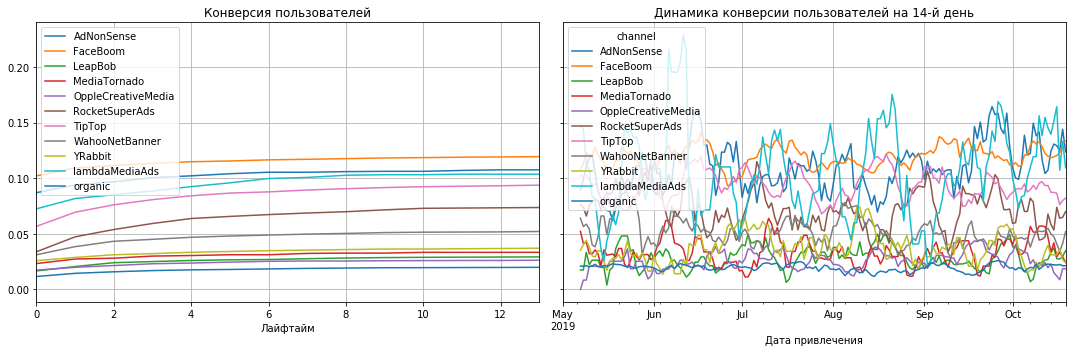

In [66]:
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Видим, что самую лучшую конверсию дают каналы FaceBoom, AdNonSense, lambdaMediaAds и TipTop.

Получается, что с конверсией всё в порядке. Перейдём к анализу удержания. Вызовем функции `get_retention()` и `plot_retention()`, чтобы рассчитать и отразить на графиках этот показатель.

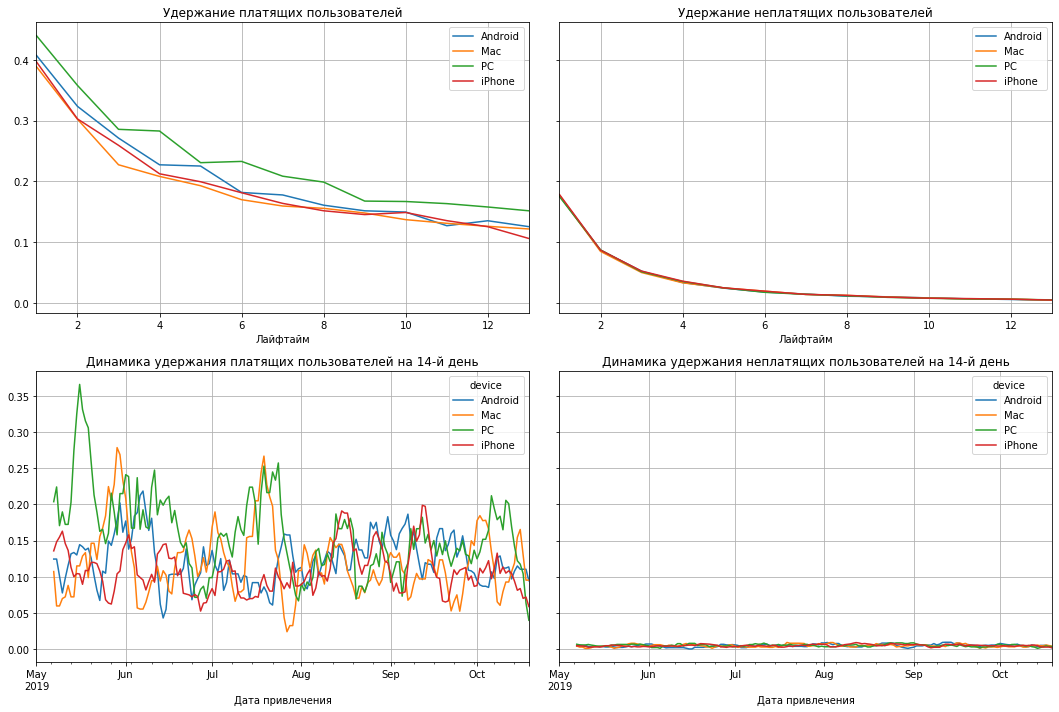

In [67]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей, как и следовало ожидать, превосходит удержание неплатящих. Однако ни среди платящих, ни среди неплатящих пользователей устройств никаких аутсайдеров не наблюдается. Построим графики с разбивкой по региону.

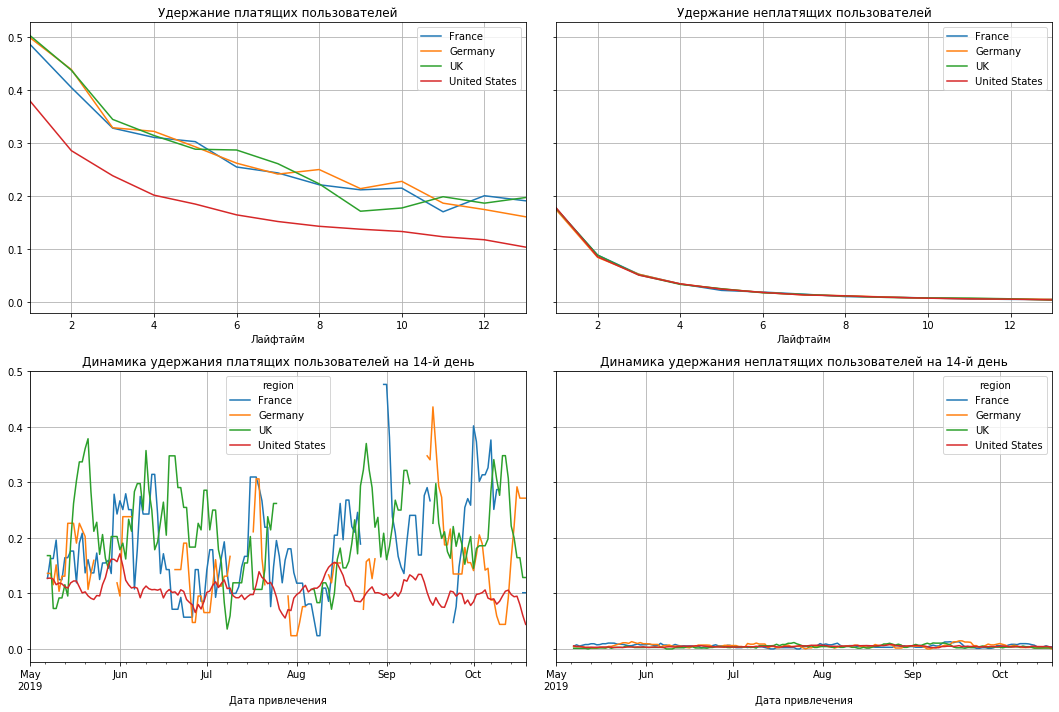

In [68]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание неплатящих пользователей из разных стран можно назвать одинаковым, а вот среди платящих выделяются пользователи из США - они почему-то удерживаются заметно хуже остальных.

Посмотрим на графики удержания с разбивкой по каналам привлечения.

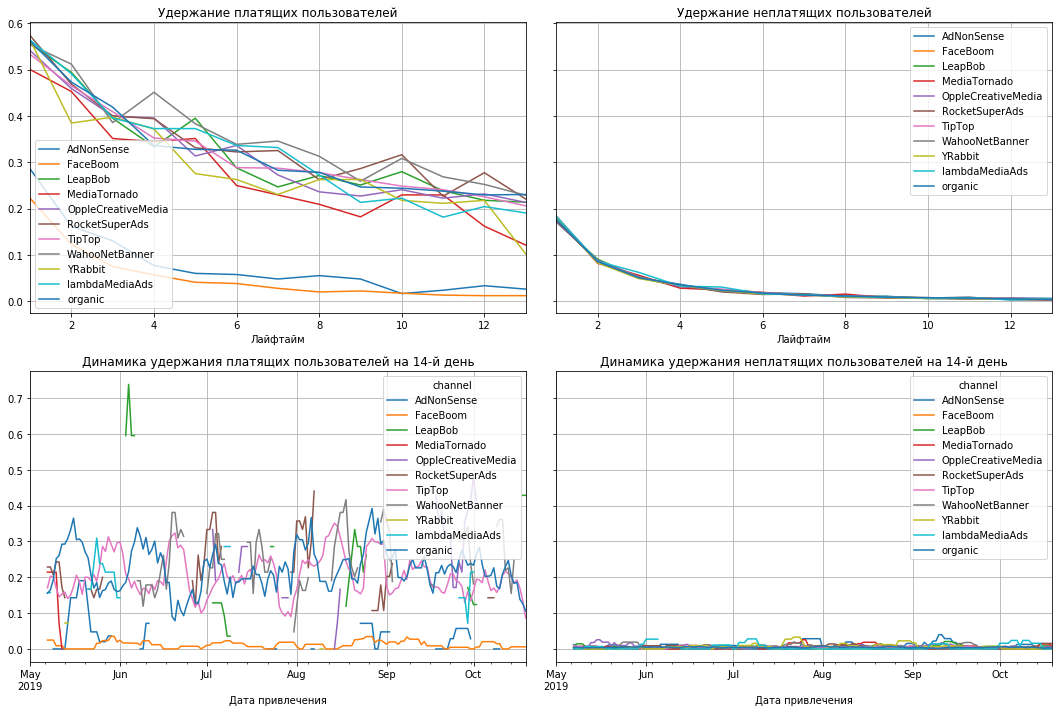

In [69]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Здесь видим два канала с низким удержанием платящих пользователей - organic и FaceBoom. Слабое удержание пользователей из огранического трафика - довольно распространённое явление, к тому же, пользователи оттуда приходят бесплатно, поэтому не будем принимать его в внимание. А вот слабое удержание из FaceBoom - важный результат.

**Вывод**

Проанализировав окупаемость рекламы для привлечения пользователей в целом, мы выяснили, что реклама в целом не окупается, а стоимость привлечения одного клиента (CAC) постоянно растёт. В процессе анализа окупаемости с разбивкой по рекламным каналам, странам и устройствам стало понятно, что есть несколько параметров, снижающих окупаемость рекламы: пользователи не окупаются из трёх источников трафика - AdNonSense, TipTop, FaceBoom, не окупаются пользователи из США и пользователи, использующие устройства iPhone и Mac. Неокупаемость рекламы сопровождается увеличением CAC для пользователей из США и для источника трафика FaceBoom. В то же время по вышеобозначенным каналам, странам и устройствам наблюдается повышенный по сравнению с остальными уровень конверсии, при этом прослеживается низкое удержание платящих пользователей из США и пользователей, приходящих из канала привлечения FaceBoom.

## Выводы


При довольно благоприятной продуктовой картине и картине продаж, где количество пользователей приложения с течением времени растёт, средняя и медианная продолжительности пользовательских сессий в приложении находятся на уровне 30 и 21 минут соответственно, а покупка в приложении совершается очень быстро (медианный промежуток времени между первым визитом и покупкой равен 70 секундам!) при среднем чеке не ниже 5 денежных единиц, мы наблюдаем неэффективность маркетинговой стратегии - в целом реклама не окупается. Причём параметов, несущих отрицательные характеристики, не так много - это:
1. не окупающие себя пользователи из США;
2. не окупающиеся пользователи устройств iPhone и Mac;
3. рекламные каналы, приносящие невыгодных для компании пользователей - AdNonSense, TipTop, FaceBoom.

Однако эти немногочисленные параметры обладают ключевым значением для всей маркетинговой кампании в целом, потому что у приложения больше половины всех пользователей - как раз из США (к тому же там самая высокая доля платящей аудитории), а самое популярное устройство среди всех пользователей - это iPhone. Что касается маркетинга, то львиная доля рекламного бюджета - более 85% - идёт на оплату привлечённого трафика через каналы AdNonSense, TipTop, FaceBoom, и это при том, что в этих каналах стоимость привлечения одного пользователя самая высокая (порой даже в 5-10 раз выше, чем по остальным каналам). Метрика удержания пользователей не лучшим образом дополняет картину - оно наименьшее среди пользователей из США (снова США!) и по источнику FaceBoom (и снова FaceBoom!). Следует также заметить, что с конверсией проблем нет ни по каким параметрам. 
<br><br>

В связи с вышесказанным формируются следующие рекомендации для отдела маркетинга для повышения эффективности:

- Необходимо помнить, что в США высокая доля пользователей готова платить, поэтому исключать из зоны охвата эту страну (как это могло бы показаться на первый взгляд) не стоит. Не пользователи в США виноваты в неэффективности рекламы, а выбранная рекламная стратегия. Такая же рекомендация по поводу пользователей iPhone.
- Перераспределить рекламный бюджет по каналам. Так как с конверсией везде всё в порядке, следует обратить внимание на другие источники трафика с меньшей стоимостью привлечения одного пользователя.
- Выяснить, почему стоимость одного привлеченного клиента (CAC) по каналу TipTop так стремительно растёт. Возможно, следует изменить некоторые настройки, чтобы стабилизировать эту стоимость. Хотя метрика CAC по каналам AdNonSense и FaceBoom стабильна, она продолжает быть самой высокой среди других, поэтому в рекламных кабинетах этих площадок также следует поработать с настройками.
- И последняя рекомендация связана с метрикой удержания. Нужно разобраться, в чём могут быть причины низкого уровня удержания для пользователей из США и пользователей, пришедших из FaceBoom. Возможно, для пользователей из некоторых стран имеет место ограничение функционала, либо некорректно подключаются сторонние сервисы (причин может быть очень много разных, о них можно строить более точные предположения, зная функционал и назначение исследуемого приложения). Причиной низкого удержания пользователей из FaceBoom может быть некорректно сформулированный рекламный призыв, когда рекламные обещания в недостаточной мере соответствуют тому, что пользователь получает в конечном итоге.

